<center> <h1 style="background-color:none; color:#1f77b4; font-size:36px; font-weight:bold; font-family:Adobe Hebrew;" >EDA, XGBoost, Lasso, KNN,  and other ML Models for Housing Price Predictions</h1></center>

**`Project Description`**
Accurately predicting housing prices is essential in the dynamic real estate market, benefiting buyers, sellers, and investors. Reliable predictions can guide investment decisions, inform pricing strategies, and enhance market stability. By using advanced data analytics and machine learning techniques, we can gain significant insights into market dynamics and accurately forecast future sales trends. In this project, we employ various machine learning ALgorithms to predict house prices based on several property attributes, such as location, size, condition, and other relevant factors.

We will use a housing dataset provided by De Cock (2011), which details residential sales in Ames, Iowa, from 2006 to 2010. This dataset includes 79 features describing the house and its corrosponding price. 

**`Mian Project Tasks`**

**`I. Data Loading, Cleaning and Preprocessing`**
- Load the dataset from Kaggle using the Kaggle API, importing it into the working directory.
- Develop an overview of the dataset, detailing data types, structure, and summary statistics to identify errors, inconsistencies, and patterns.
- Handle missing values and duplicates within the dataset.
- Ensure data schema consistency by addressing irregularities in data entries.
- Inspect and treat any outliers in the data.

**`II. Explanotary Data Analysis`**

During EDA, we will visualize the features and target data using histograms, box plots, scatterplots, and density plots. This process helps understand data distribution and central tendency, providing insights for feature engineering. Our analysis will cover univariate, bivariate, multivariate, and time series analyses..

**`II. Feature Engineering`**
- Identify relevant features based on EDA, using domain knowledge or feature ranking algorithms.
- Create new features from existing ones if necessary.
- Encode and scale features, converting categorical features into numerical representations and scaling them for improved algorithm performance.

**`IV. Machine Learning Implementation`**
- Select Candidate Machine Learning algorithms- 
- Make Base evaluation and identify better performing and/promosing models
- Hyperparatemer tuning of the models- we fine-tune models hyperparameters to further improve  its performance.
Finally, we validate the selected model on test data, indentify important features for the model and save model for future use.

# **<font color="teal" size="6" face="Adobe Garamond Pro">1. Import Libraries and frameworks</font>**

In [1]:
import pandas as pd
import numpy as np
import kaggle # To load or import dataset to local or cloud using using kaggle API
import os 
import zipfile
import datetime
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor, plot_importance
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score

In [2]:
#for visualization- we use matplotlib, seaborn and ploty
import matplotlib.pyplot as plt # 
import seaborn as sns
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots # plot subplot with plotly.graph_objects

def set_default_style():
    plt.style.use(['ggplot'])
    plt.rc('font', family='Adobe Garamond Pro')
    plt.rc('axes', edgecolor='w', titlesize=12, titleweight='bold', labelweight='bold', labelsize=10, grid=False)
    plt.rc('text', color='tomato')
    plt.rc('figure', figsize=(9, 3.5), dpi=150)
    # for ploty plot
    px.defaults.template = 'seaborn'
    px.defaults.width = 900
    px.defaults.height = 350
    px.defaults.color_continuous_scale = px.colors.sequential.Plasma_r 
    px.defaults.color_discrete_sequence = px.colors.qualitative.T10
set_default_style()
# color = #402653, #8E4771, #D67177, #EE8C5B, #FFD887, #5684A5
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 100) 
pd.set_option('display.width', 400) 
pd.options.display.float_format = '{:20.2f}'.format # display only three decimal place
np.random.seed(0) # set seed for reproductibility
import warnings
warnings.filterwarnings("ignore") 

## **<font color="teal" size="6" face="Adobe Garamond Pro">2. Load/Import and Read the datasets</font>**

In [3]:
#Load the datasets
!kaggle competitions download -c 'house-prices-advanced-regression-techniques'
os.makedirs('data/Housing/', exist_ok=True)
!unzip house-prices-advanced-regression-techniques.zip -d 'data/Housing/'
os.remove('house-prices-advanced-regression-techniques.zip')

  0%|                                                | 0.00/199k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 199k/199k [00:00<00:00, 3.29MB/s]
Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data/Housing/data_description.txt  
  inflating: data/Housing/sample_submission.csv  
  inflating: data/Housing/test.csv   
  inflating: data/Housing/train.csv  


In [5]:
#read the dataset
df_train = pd.read_csv('data/Housing/train.csv') # used for training and validationset
df_test = pd.read_csv('data/Housing//test.csv') # unseen data
print(f" The dataset have:\n Training Set with {df_train.shape}\n Testing Set with {df_test.shape}")

 The dataset have:
 Training Set with (1460, 81)
 Testing Set with (1459, 80)


**`Observation from reading the dataset`**

Training set have 1460 instance/rows and 81 features, whereas test set have also 1459 instances and the same features except the last one `SalePrice` which is target feature we are aiming to predict. The feature names has been abreaviated or shorted for readability. Here is description of features for more understanding/references.
| Feature         | Description                                                            | Feature         | Description                                                            |
|-----------------|------------------------------------------------------------------------|-----------------|------------------------------------------------------------------------|
| 1stFlrSF        | First floor area in square feet                                        | HalfBath        | Half bathrooms above ground                                            |
| 2ndFlrSF        | Second floor area in square feet                                       | Heating         | Heating type                                                           |
| 3SsnPorch       | Three season porch area in square feet                                 | HeatingQC       | Heating quality and condition                                          |
| Alley           | Type of alley access to the house                                      | HouseStyle      | House style                                                            |
| Bedroom         | Bedrooms above ground                                                  | Kitchen         | Kitchens above ground                                                  |
| BldgType        | House type                                                             | KitchenQual     | Kitchen quality                                                        |
| BsmtCond        | Basement Condition                                                     | LandContour     | House flatness                                                         |
| BsmtExposure    | Refers to walkout or garden level walls                                | LandSlope       | House Slope                                                            |
| BsmtFinSF1      | Type 1 finished square feet                                            | LotArea         | Lot size in square feet                                                |
| BsmtFinSF2      | Type 2 finished square feet                                            | LotConfig       | Lot configuration                                                      |
| BsmtFinType1    | Rating of basement finished area                                       | LotFrontage     | Linear feet of street connected to the house                           |
| BsmtFinType2    | Rating of basement finished area (if multiple types)                   | LotShape        | General shape of the house                                             |
| BsmtFullBath    | Basement full bathrooms                                                | LowQualFinSF    | Low quality finished square feet in all floors                         |
| BsmtHalfBath    | Basement half bathrooms                                                | MSSubClass      | The type of the house involved in the sale                             |
| BsmtQual        | Basement height                                                        | MSZoning        | The general zoning classification of the sale                          |
| BsmtUnfSF       | Unfinished basement area in square feet                                | MasVnrArea      | Masonry veneer area in square feet                                     |
| CentralAir      | Central air conditioning                                               | MasVnrType      | Type of masonry veneer                                                 |
| Condition1      | Proximity to various conditions                                        | MiscFeature     | Miscellaneous feature                                                  |
| Condition2      | Proximity to various conditions (if more than one is present)          | MiscVal         | Value of miscellaneous feature                                         |
| Electrical      | Electrical system type                                                 | MoSold          | Sale month                                                             |
| EnclosedPorch   | Enclosed porch area in square feet                                     | Neighborhood    | Locations within Ames city limits                                      |
| ExterCond       | Condition of the material on the exterior                              | OpenPorchSF     | Open porch area in square feet                                         |
| ExterQual       | Quality of the material on the exterior                                | OverallCond     | Overall condition of the house                                         |
| Exterior1st     | Exterior covering on house                                             | OverallQual     | Overall quality of material and finish of the house                    |
| Exterior2nd     | Exterior covering on house (if more than one material)                 | PavedDrive      | How driveway is paved                                                  |
| Fence           | Fence quality                                                          | PoolArea        | Pool area in square feet                                               |
| Fireplaces      | Number of fireplaces                                                   | PoolQC          | Pool quality                                                           |
| FireplaceQu     | Fireplace quality                                                      | RoofMatl        | Roof material                                                          |
| Foundation      | Foundation type                                                        | RoofStyle       | Roof type                                                              |
| FullBath        | Full bathrooms above ground                                            | SaleCondition   | Sale condition                                                         |
| GarageArea      | Garage size in square feet                                             | SaleType        | Sale type                                                              |
| GarageCars      | Size of garage (in car capacity)                                       | ScreenPorch     | Screen porch area in square feet                                       |
| GarageCond      | Garage condition                                                       | Street          | Type of road access to the house                                       |
| GarageFinish    | Interior finish of the garage                                          | TotRmsAbvGrd    | Total rooms above ground (excluding bathrooms)                         |
| GarageQual      | Garage quality                                                         | TotalBsmtSF     | Total basement area in square feet                                     |
| GarageType      | Garage location                                                        | Utilities       | Type of utilities available                                            |
| GarageYrBlt     | Year garage was built in                                               | WoodDeckSF      | Wood deck area in square feet                                          |
| GrLivArea       | Above-ground living area in square feet                                | YearBuilt       | Construction year                                                      |
| FullBath        | Full bathrooms above ground                                            | YearRemodAdd    | Remodel year (if no remodeling nor addition, same as YearBuilt)        |
| YrSold          | Sale year                                                              |



## **<font color="teal" size="6" face="Adobe Garamond Pro">3. Data Cleaning and Preprocessing</font>**
- First `Develop an overview` that includes key details about the datasets, such as data types, structure, and summary statistics. This will help identify errors, inconsistencies, or patterns, aiding in further data cleaning and preprocessing.'
- Identify and handle datasets and corrosponding columns with `missing values and duplicates`.
- Identify and handle `Irregularities in Data Entries` - data schema consistence
- Inspecting data for any outliers and treatment of those `outliers`

#### `3.1 Explore the datasets`


In [6]:
# Explore dataset across data schema
def explore_dataset(dfs):
    summary = []
    for column in sorted(dfs.columns):  # Sort the columns alphabetically
        data_type = dfs[column].dtype
        total_count = len(dfs[column])
        unique_count = dfs[column].nunique()
        unique_sample = dfs[column].unique()[0:10]
        missing_values = dfs[column].isnull().sum()
        summary.append({'Column': column, 'Data Type': data_type, 'Total Count': total_count,
                        'Unique Count': unique_count, 'Unique Sample': unique_sample, 
                        'Missing Values': missing_values})
    return pd.DataFrame(summary)

# Explore training dataset
print(f"                               Explore Training Dataset Key Information")
print("------- " * 15, '\n', explore_dataset(df_train))
# print("------- "*15, '\n', explore_dataset(df_test)) # evaluate for test_set too.


                               Explore Training Dataset Key Information
------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- -------  
            Column Data Type  Total Count  Unique Count                                      Unique Sample  Missing Values
0        1stFlrSF     int64         1460           753  [856, 1262, 920, 961, 1145, 796, 1694, 1107, 1...               0
1        2ndFlrSF     int64         1460           417  [854, 0, 866, 756, 1053, 566, 983, 752, 1142, ...               0
2       3SsnPorch     int64         1460            20   [0, 320, 407, 130, 180, 168, 140, 508, 238, 245]               0
3           Alley    object         1460             2                                  [nan, Grvl, Pave]            1369
4    BedroomAbvGr     int64         1460             8                           [3, 4, 1, 2, 0, 5, 6, 8]               0
5        BldgType    object         1460             5              [1Fam

**Observations from Dataset Exploration**

- The dataset contains numerous features with missing values, which need to be addressed appropriately.
- The dataset includes features with both categorical (object) and numerical (int and float) data types. Since machine learning models typically require numerical input, we will need to convert categorical features to numerical ones using various techniques, such as encoding.
- Some features have a large number of unique values, while others have only a few.

**Next Steps**

- Identify and handle datasets and corresponding columns with missing values and duplicates.
- Inspect the data for any outliers and implement appropriate treatments for these outliers.


#### `3.2 Identify Column with Missing and Duplicate Values`

In [7]:
#identify feature with missing values, its datypes and nunique values, missing values count both in train and test dataset
def check_missing_values(*datasets):
    missing_values_dict = {}
    
    for dataset_name, dataset in datasets:
        missing_values_count = dataset.isnull().sum()
        dtypes = dataset.dtypes
        unique_counts = dataset.nunique()
        
        for feature, missing_count in missing_values_count.items():
            if missing_count > 0:
                if feature not in missing_values_dict:
                    missing_values_dict[feature] = {'Data Type': str(dtypes[feature]),
                                                    'Unique Count': unique_counts[feature],
                                                    'Unique_Sample': dataset[feature].unique()[0:10],
                                                    'Missing Values(Train)': 0,
                                                    'Missing Values(Test)': 0}
                if dataset_name == "Training dataset":
                    missing_values_dict[feature]['Missing Values(Train)'] = missing_count
                elif dataset_name == "Testing dataset":
                    missing_values_dict[feature]['Missing Values(Test)'] = missing_count

    # Convert the dictionary to a DataFrame
    missing_values_df = pd.DataFrame.from_dict(missing_values_dict, orient='index')
    missing_values_df = missing_values_df.sort_values(by='Missing Values(Train)', ascending=False)
    
    return missing_values_df

print("                               Summary of missing values and key information to handle missing values:")
print("------- " * 15, '\n', check_missing_values(("Training dataset", df_train), ("Testing dataset", df_test)))

# Check Duplicates Counts of dupliacate rows if any
def check_duplicates_row(*datasets):
    for dataset_name, dataset in datasets:
        duplicate_count = dataset.duplicated().sum()
        print(f"{dataset_name} has {duplicate_count} duplicate rows.")
print("\n\n                              Summary of no of duplicates rows if any in the dataset:", '\n', "------- " * 15)
check_duplicates_row(("Training dataset", df_train), ("Testing dataset", df_test))

                               Summary of missing values and key information to handle missing values:
------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- -------  
              Data Type  Unique Count                                      Unique_Sample  Missing Values(Train)  Missing Values(Test)
PoolQC          object             3                                  [nan, Ex, Fa, Gd]                   1453                  1456
MiscFeature     object             4                      [nan, Shed, Gar2, Othr, TenC]                   1406                  1408
Alley           object             2                                  [nan, Grvl, Pave]                   1369                  1352
Fence           object             4                    [nan, MnPrv, GdWo, GdPrv, MnWw]                   1179                  1169
MasVnrType      object             3                      [BrkFace, nan, Stone, BrkCmn]                    87

**Observations**

- The dataset exhibits a considerable number of features with significant missing values.
- Notably, features with the highest count of missing values predominantly object dtypes. Upon closer examination of sample unique values, it becomes evident that these missing values convey alternative information rather than simply indicating null values. For instance, consider the feature 'PoolQC', which denotes the quality of the pool. The unique values include 'Ex' for excellent, 'Gd' for good, 'Fa' for fair, and 'nan', where 'nan' signifies the absence of a pool in the house. This pattern holds true for most features with object dtypes.

### `3.2 Handling Missing Values and Duplicates`

Fortunately, we do not have duplicate rows in any of the datasets, as indicated by the summary output above. Therefore, we only need to address missing values. There is no standard rule for imputing missing values, but general intuition can guide our approach. If we know the missing values do not exist, we drop them. However, if we assume they exist but were not recorded correctly, we apply different methods based on the data type.

- For categorical features (object or bool dtype) - use the mode to impute null values with the most common value.
- For numerical features (int or float dtype) - use the mean.
- For numerical features with datetime dtype - use the median.
- For time series features - use forward fill (ffill) or backward fill (bfill).
- Otherwise, apply domain knowledge.

**`Handling Missing Values`**

**Categorical Features**
- **PoolQC**: Null values indicate the house does not have a pool. Replace with 'NoPool'.
- **MiscFeature**: Null values indicate the house does not have miscellaneous features. Replace with 'NoMiscFea'.
- **Alley, Fence, MasVnrType, FireplaceQU**: Null values indicate the house does not have an alley, fence, masonry veneer, or fireplace. Replace with 'NoAlley', 'NoFence', 'NoMasonry', and 'NoFirePlace', respectively.
- **GarageType, GarageFinish, GarageQual, GarageCond**: Null values indicate the house does not have a garage. Replace with 'NoGarage'.
- **BsmtFinType2, BsmtExposure, BsmtFinType1, BsmtQual, BsmtCond**: Null values indicate the house does not have a basement. Replace with 'NoBsmt'.
- **MSZoning**: Null values indicate the house has not been assigned to a specific zone. Replace with 'NoZone'.
- The remaining categorical features ("Electrical, Functional, KitchenQual, Utilities, Exterior2nd, Exterior1st, MSZoning, SaleType") have only one or two missing values. Use the mode to impute null values with the most common value.

**Numerical Features**
- **LotFrontage**: Null values indicate the house is not connected to any street. Replace with '0'.
- **GarageYrBlt**: Null values indicate the house does not have a garage. Replace with '0' or the median. Since a zero datetime feature does not make sense, further feature engineering may be required.
- **MasVnrArea**: Null values indicate the house does not have masonry veneer. Replace with '0'.
- The remaining numerical features ("TotalBsmtSF, GarageArea, GarageCars, BsmtHalfBath, BsmtFullBath, BsmtUnfSF, BsmtFinSF2, BsmtFinSF1") have only one or two missing values. Replace with the mean, forward fill (ffill), or backward fill (bfill) depending on the criteria above.

In [8]:
# Create a copy of Original DataFrames for references
df = df_train.copy()  
df_test = df_test.copy()  
datasets = [("Training dataset", df), ("Testing dataset", df_test)]

def handle_missing_values(**datasets):
    # Dictionary for categorical features with specific fill values: Feature name: value to replace nan value with
    cat_specific_fill = {'PoolQC': 'NoPool', 'MiscFeature': 'NoMiscFea', 'Alley': 'NoAlley',
                         'Fence': 'NoFence', 'MasVnrType': 'NoMasonry', 'FireplaceQu': 'NoFirePlace',
                         'GarageType': 'NoGarage', 'GarageFinish': 'NoGarage', 'GarageQual': 'NoGarage',
                         'GarageCond': 'NoGarage', 'BsmtFinType2': 'NoBsmt', 'BsmtExposure': 'NoBsmt',
                         'BsmtFinType1': 'NoBsmt', 'BsmtQual': 'NoBsmt', 'BsmtCond': 'NoBsmt', 'MSZoning': 'NoZone'}

    # List of categorical features to fill with mode
    cat_mode_fill = ['Electrical', 'Functional', 'KitchenQual', 'Utilities', 'Exterior2nd', 'Exterior1st', 'SaleType']

    # Dictionary for numerical features with specific fill values
    num_spec_fill = {'LotFrontage': 0, 'GarageYrBlt': 0,  'MasVnrArea': 0}

    # List of numerical features to fill with mean
    num_mean_fill = ['TotalBsmtSF', 'GarageArea', 'GarageCars', 'BsmtHalfBath', 'BsmtFullBath', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1']

    for dataset in datasets.values():
        for col, value in cat_specific_fill.items(): dataset[col].fillna(value, inplace=True) 
        for col in cat_mode_fill: dataset[col].fillna(dataset[col].mode()[0], inplace=True)
        for col, value in num_spec_fill.items(): dataset[col].fillna(value, inplace=True)
        for col in num_mean_fill: dataset[col].fillna(dataset[col].mean(), inplace=True)
    return datasets

# Example usage
datasets = {"Training dataset": df, "Testing dataset": df_test}
datasets = handle_missing_values(**datasets)

In [9]:
# Confirm all missing values are handled
def check_missing_values(*datasets):
    for dataset_name, dataset in datasets:
        missing_values_count = dataset.isnull().sum()
        if missing_values_count.sum() == 0:
            print(f"No missing values in {dataset_name}")
        else:
            print(f"Missing values in {dataset_name}:")
            print(missing_values_count)
# Print summary of missing values
print("Summary of missing values:")
check_missing_values(("Training dataset", df), ("Testing dataset", df_test))
print("￣ ￣ ￣"*10)

Summary of missing values:
No missing values in Training dataset
No missing values in Testing dataset
￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣


#### `3.3 Handling Irregularities and Drop Unnecessary Feature's`
All the the features seems have no irregularities in both training and test dataset, except 'Utilities', feature, where it seems it has only one unique values and one observation of missing values later handled. Since, it won't contribute to model supervision, we can ignore or delete. We can simalary check for other feature with less than two unique values. 
The 'Id' feature is just sequence of data entry and don't contribute supervising our model, hence we can remove them.

In [10]:
def two_unique_columns(dfs):
    for column in dfs.columns:
        unique_counts = dfs[column].nunique()
        if unique_counts <= 2:
            print(f"Column '{column}' in dataframe:\n{dfs[column].value_counts()}\n")
print("Value counts:", two_unique_columns(df)) # try the same for df_test

Column 'Street' in dataframe:
Street
Pave    1454
Grvl       6
Name: count, dtype: int64

Column 'Utilities' in dataframe:
Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64

Column 'CentralAir' in dataframe:
CentralAir
Y    1365
N      95
Name: count, dtype: int64

Value counts: None


In [11]:
# Drop these features from the training dataset, ignoring errors if they don't exist
df = df.drop(columns=['Utilities', 'Street'], errors='ignore')
df_test = df_test.drop(columns=['Utilities', 'Street'], errors='ignore')

#### `3.4 Detecting and Handling Outliers`

Outliers are often defined as data points that fall outside a certain range, like 1.5 times the interquartile range (the difference between Q3 and Q1). The same range is considered to detect outliers in our data points. If the data points have a normal distribution, the outlier data points will be 0.7% of the data. Check counts of outlier data points for feature with numerical values. 

In [12]:
# Identify features with outliers data points in both training and testing. 
def find_outliers(df_name, dfs):
    numeric_columns = [col for col in dfs.columns if dfs[col].dtype in ['float64', 'int64']]
    for col_name in numeric_columns:
        Q1 = dfs[col_name].quantile(0.25) # Calculate the 1st quartiles
        Q3 = dfs[col_name].quantile(0.75)  # Calculate the 3rd quartiles
        IQR = Q3 - Q1  # Calculate tinterquartile
        
        # Filter outliers based on IQR
        outliers = dfs[(dfs[col_name] < Q1 - 1.5 * IQR) | (dfs[col_name] > Q3 + 1.5 * IQR)]
        print(f"Total outliers in {col_name} column: {outliers.shape[0]}")

datasets = [("Combined Dataset", df)]
# Call the function to find outliers in all numeric columns for each dataset
for idx, (df_name, dataset) in enumerate(datasets, start=1):
    print(f"{idx}.{df_name} outliers:")
    find_outliers(df_name, dataset)
    print("￣ ￣ ￣"*8 if idx !=len(datasets) else '')

1.Combined Dataset outliers:
Total outliers in Id column: 0
Total outliers in MSSubClass column: 103
Total outliers in LotFrontage column: 16
Total outliers in LotArea column: 69
Total outliers in OverallQual column: 2
Total outliers in OverallCond column: 125
Total outliers in YearBuilt column: 7
Total outliers in YearRemodAdd column: 0
Total outliers in MasVnrArea column: 98
Total outliers in BsmtFinSF1 column: 7
Total outliers in BsmtFinSF2 column: 167
Total outliers in BsmtUnfSF column: 29
Total outliers in TotalBsmtSF column: 61
Total outliers in 1stFlrSF column: 20
Total outliers in 2ndFlrSF column: 2
Total outliers in LowQualFinSF column: 26
Total outliers in GrLivArea column: 31
Total outliers in BsmtFullBath column: 1
Total outliers in BsmtHalfBath column: 82
Total outliers in FullBath column: 0
Total outliers in HalfBath column: 0
Total outliers in BedroomAbvGr column: 35
Total outliers in KitchenAbvGr column: 68
Total outliers in TotRmsAbvGrd column: 30
Total outliers in Fir

We have identified that quite a few features has an outlier datat points. Outlier in target predictor features, reflected on oultier on Target features, Hence, if we removed one outlier in Target features, the correspind predictor which cause, will be removed along with.  We shouldn't remove data points because its identified as an outlier , we shoulde ensure it is  `incorrectly entered instance or measerument error to drop it`, or esle we apply transformation if the outliers ara at an extream end of the data points. Lets evaluate distribution of Target feature and predictor features with the most outliers data points and see indeed if the data points are indeed outliers needs to be removed.`

## **<font color="teal" size="6" face="Adobe Garamond Pro">4. Explanatory Data Analysis (EDA)</font>**

#### 4.1 `Uni-variate Analysis for continous variables`
Because, our datasets have multiple features, analysing each features is cumbersome and not productive. However, we will do for  the target feature, the most important variable. We examine the distribution of data points, identify outliers. We will use historgram, scatter plot and boxplot to visialize the distribtion of the data points and identify outliers.

In [13]:
# Create subplots
fig = make_subplots(rows=1, cols=3, column_widths=[0.4, 0.3, 0.3])

fig.add_trace(go.Histogram(x=df['SalePrice'], nbinsx=80, name="SalesPrice"), row=1, col=1)
fig.add_trace(go.Scatter(y=df['SalePrice'], mode='markers', marker_size=8, name="Sales Price"), row=1, col=2)
fig.add_trace(go.Box(y=df['SalePrice'], boxpoints='all', jitter=0.3, pointpos=-1.8, marker_color='darkgray', name='SalesPrice'), row=1, col=3)

fig.update_xaxes(showgrid=False, rangemode='nonnegative')
fig.update_yaxes(title_text='Values', showgrid=False, rangemode='nonnegative')
fig.update_yaxes(title_text='Frequency', showgrid=False, rangemode='nonnegative', row=1, col=1)

fig.update_layout(font_family="Open Sans",
                  title=dict(text='Training Datasets Outliers', font=dict(size=22, color='navy'), x=0.5),
                  margin=dict(t=50, b=10, l=10, pad=0), 
                  width=1200, height=400,
                  template='seaborn')
fig.update_traces(marker_line_color='black', marker_line_width=1, opacity=1, showlegend=False)
fig.show()

**Observation**:

The histogram plot indicates that the distribution of data points is slightly skewed to the left, suggesting that normalizing the feature would be beneficial. We can see that most house prices fall between 80K and 230k. We see also that there is a number of expensive houses to the right of the plot.The plot also reveals a few data points at the extreme end, hinting at the presence of outliers. The scatter plot shows the distribution of SalePrice against the index, indicating that the data is uniformly distributed along the index, which suggests there are no error entries at specific indices. The boxplot, when hovered over, describes the maximum, minimum, first quartile, third quartile, whisker positions, and outlier data points.

When we look at a plot, we see that the outliers are spread out evenly throughout the data except for couple of data points and don't seem to be caused by mistakes or errors in recording. They're not at the extreme ends of the data either. So, we shouldn't just remove them because they might actually be important pieces of information. Instead, we should further investigate them in the bi_variate or multivariate process to understand why they're there and what they might tell us about the data.

#### 4.2 `Bivariate and Multivariate Analysis`
-  We start by examining the correlation between target features and predictor features  with numerical and boolen data type using correlation matrices(heatmap). Then, we explore these relationships further using scatter plots and other multivariate techniques to fully understand the data dynamics, detect oultiers and which variables causing outliers, identify important features. 

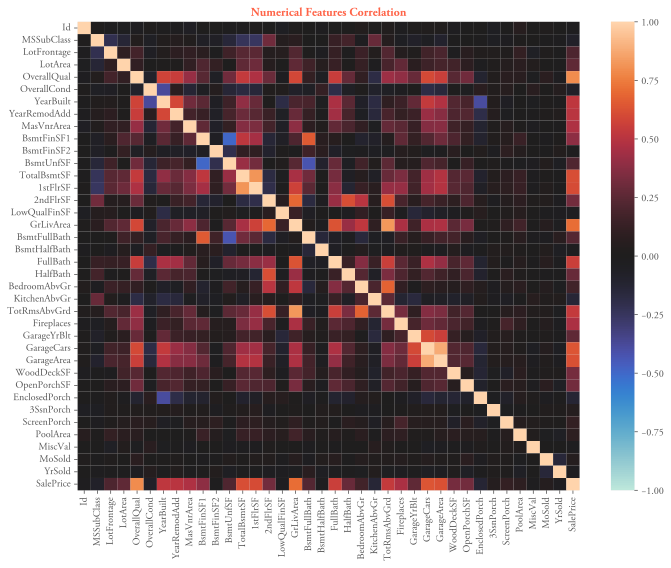

In [14]:
cols = [col for col in df.columns if df[col].dtype in ['float64', 'int64', 'bool']]
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df[cols].corr(), vmin=-1, vmax=1,  cmap='icefire', ax = ax)
plt.title("Numerical Features Correlation")
plt.tight_layout()
plt.show() 

The heatmap illustrates the correlation between numerical and boolean dtype features. It is evident that many features are correlated. Our primary interest is in determining the correlation between predictor features and the target feature (SalesPrice). Accordingly, we will examine how each predictor feature is correlated with the target feature.

A visible reversed L-shaped pattern in the heatmap provides crucial insights. Some features have no or insignificant correlation with the target feature or with other predictor features. These features include `MoSold`, `3SsnPorch`, `BsmtFinSF2`, `BsmtHalfBath`, `MiscVal`, `Id`, `LowQualFinSF`, and `YrSold`. Therefore, we should consider dropping these features and creating new ones that could improve our model’s performance or have a stronger correlation with the target feature.

Let's plot the correlation strength of predictor features with SalesPrice.

In [15]:
#plot correlation strenghth of predictor faeture against target
corr_matrix = df[cols].corr()
sorted_corr = corr_matrix['SalePrice'].sort_values(ascending=False)[1:] 
corr_df = sorted_corr.reset_index() 
corr_df.columns = ['Feature', 'corr_with_SalePrice']

# Plot a bar plot of the correlations using Plotly
fig = go.Figure(go.Bar(x=corr_df['corr_with_SalePrice'], 
                       y=corr_df['Feature'],  
                       orientation='h', 
                       name='Correlation',
                       hovertemplate="<b>Feature:</b> %{y}<br><b>Correlation:</b> %{x}"))
fig.update_xaxes(showgrid=False,  title_text='Correlation with SalePrice', dtick=0.1)
fig.update_yaxes(showgrid=False,  title_text='Predictor Features', autorange='reversed')
fig.update_traces(marker_line_color='black', marker_line_width=0.75, opacity=1, showlegend=False)
fig.update_layout(font_family="Adobe Garamond Pro",
                  title=dict(text='Predictor Features Correlation with Target Feature(SalePrice)', font=dict(size=22, color='navy'), x=0.5),
                  margin=dict(t=40, b=10, l=10, r=10, pad=0), 
                  width=850, height=650,
                  template='seaborn')
fig.show()

For the plot above, we have identified and sorted features that are strongly correlated with the target feature. Several features, including OverallQual and GarageCars, are highly positively correlated with the target feature, meaning the values of these features directly influence the sales price of the house, and our machine learning model learns this relationship. On the other hand, KitchenAbvGr, MSSubClass, and YrSold are negatively correlated with the target feature, indicating that higher values of these features are associated with lower house prices. Features previously identified as not having significant correlation show correlation strengths between -0.05 and 0.05, such as Overall.

We further explore these correlationusing scattor plot, there by identify outlier to remove and evaluate distribution predictor features compared to outliers. We examine predictor feature predictors with moderate to high  positve or negative coreralioin. 

In [16]:
# Filter columns with correlation less than -0.1(for -ve corr) or above  0.5 for +ve corr
filtered_corr_df = corr_df[(corr_df['corr_with_SalePrice'] < -0.1) | (corr_df['corr_with_SalePrice'] > 0.5)].set_index('Feature')
filtered_corr_df.T

Feature,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,EnclosedPorch,KitchenAbvGr
corr_with_SalePrice,0.79,0.71,0.64,0.62,0.61,0.61,0.56,0.53,0.52,0.51,-0.13,-0.14


We have identified total of 12 features to further examines, some of them are continous numerical value while othes are discreate datatype. We use disceate numerical features with quit few values to color or size other continues numerical value features. We attempt to compare related features, Garage, Living room, and others.

In [17]:
features = filtered_corr_df.index.tolist()
# create a plot function to use again after outlier removal if any
def plot(df, features):
    fig = make_subplots(rows=4, cols=3, column_widths=[0.4, 0.3, 0.3], vertical_spacing=0.05, subplot_titles=features)
    y = df['SalePrice']
    for i, feature in enumerate(features, start=1):
        fig.add_trace(go.Scatter(x=df[feature], y=y, mode='markers', name=feature), row=(i - 1) // 3 + 1, col=(i - 1) % 3 + 1)
    fig.update_xaxes(showgrid=False, rangemode='nonnegative')
    fig.update_yaxes(showgrid=False, rangemode='nonnegative')
    fig.update_layout(font_family="Open Sans",
                      title=dict(text='SalesPrice vs Selected Predictor Features Correlation', font=dict(size=22, color='navy'), x=0.5),
                      margin=dict(t=50, b=10, l=10, pad=0),
                      width=1250, height=800,
                      template='seaborn')
    fig.update_traces(marker_line_color='black', marker_line_width=1, opacity=1, showlegend=False)
    fig.show()
plot(df, features)

**Observation**

The scatter plot visualizes the correlation between SalesPrice and selected predictor features. An important observation is the presence of outliers. Upon hovering over each plot, we notice approximately four outlier data points, primarily in GrLivArea and also in most other features. These data points correspond to SalesPrice values of [160k, 184.75k, 745k, 755k]. We can address this issue by setting limits on GrLivArea and SalesPrice to exclude these data points.

In [18]:
#Romve outliers 
df = df.copy()
df_test = df_test.copy()
print('shape before outlier removel:', df.shape, df_test.shape) #shape before outlier removal
df = df[(df['GrLivArea'] < 4000) & (df['SalePrice'] < 700000)]
# df_test = df_test[df_test['GrLivArea'] < 40000]
print('shape after outlier removal:', df.shape, df_test.shape)

shape before outlier removel: (1460, 79) (1459, 78)
shape after outlier removal: (1456, 79) (1459, 78)


Luckly, the outlier data points in existed in training dataset do not exist in the training dataset

In [19]:
#let plot distriution of those feature after outlier removed
plot(df, features)


**Observation**
- We can see that OverallQual and GrLivArea are the most correlated predictor features, showing a strong direct and linear correlation with the price.
- Although GarageCars and GarageArea show a high positive correlation, the house price tends to decrease when the number of cars a garage can accommodate exceeds three or when the garage area is larger than 1000 square units. Ideally, we prefer to have a large garage, but not excessively large.
- TotalBsmtSF and 1stFlrSF show a moderate positive correlation with the price, with SalePrice increasing as the area gets larger.
- Generally, houses built later, particularly around the year 2000, are slightly more expensive than older ones. Interestingly, having too many kitchens above ground level tends to reduce the house price. EnclosedPorch Area is also negetively correlated.

## **<font color="teal" size="6" face="Adobe Garamond Pro">5. Feature Engineering</font>**

**Feature Encoding** 

Most of the the machine learning algorithms works with numerical values, it is imperative to encode categorical variables into numeric ones unless they are to be discarded. The choice of encoding method depends on factors such as the number of unique categories in the features and whether the category is nominal or ordinal.
- In cases where the category is nominal and the order of the categories is insignificant, and there are only a few unique values (e.g. Pave), one-hot encoding is applied. However, it's important to acknowledge that employing One-Hot Encoding may lead to a significant increase in the number of features, potentially causing the "curse of dimensionality" if the number of unique categories is excessively high.
- For ordinal categories, where the order of the data holds significance, label encoding is preferred.

*Ordinal Categorical Features*- Based on the close to the datatypes and its unique values during dataset explore and EDA, we have identified the following predictor features as having ordinal categorical values. Most the features values are ranking and some sort of order. I.E. GarageQual is has [TA, Fa, Gd, NoGarage, Ex, Po] where "TA" means "Typical", "Fa" means "Fair", "Gd" is "Good", "Ex" means "Excellent" and "Po" means "Poor". As such we can map number from 5 to 0, for 5 mapped to excellent and 0 mapped to No Garage. The list includes

In [20]:
ord_cat_ftrs=['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'ExterCond', 
          'ExterQual', 'Functional', 'Fence', 'FireplaceQu', 'GarageCond', 'GarageFinish', 'GarageQual', 
          'HeatingQC', 'KitchenQual', 'LandSlope', 'PoolQC']

*Nominal Categorical Features*- features are those where the categories have no inherent order or ranking. this include**

In [21]:
nom_cat_ftrs=['Alley', 'BldgType', 'Condition1', 'Condition2', 'Electrical', 'Exterior1st', 'Exterior2nd',
          'Foundation', 'GarageType', 'Heating', 'HouseStyle', 'LandContour', 'LotConfig', 'LotShape', 
          'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive', 'RoofMatl', 'RoofStyle', 
          'SaleCondition', 'SaleType']

`5.1 Label Encoding`

In [22]:
# Set display options to show all items in a cell
pd.set_option('display.max_colwidth', 100)  # Show all contents of each cell without truncation
#let print their unique values and counts, see if ther is matching ordinal or if need to delete the feature
def ordinal_feature_unique_value(dfs, ord_cat_ftrs):
    summary = []
    total_unique_count = 0
    for feature in sorted(ord_cat_ftrs):  # Sort the columns alphabetically
        data_type = dfs[feature].dtype
        unique_count = dfs[feature].nunique()
        value_counts = dfs[feature].value_counts().to_dict()  # Get value counts as a dictionary
        summary.append({'Ordinal_Feature': feature, 'Data Type': data_type,
                        'Unique Count': unique_count, 'Value Counts': value_counts})
        total_unique_count += unique_count 
    print("Total Unique Count:", total_unique_count) 
    return pd.DataFrame(summary)

def explore_ordinal_features(dataframes, ord_cat_ftrs):
    for name, dfs in dataframes.items():
        print(f"\n                             Explore {name} Unique value counts and list")
        print("------- " * 15)
        summary = ordinal_feature_unique_value(dfs, ord_cat_ftrs)
        print(summary)

# Example usage:
dataframes = {'Training': df, 'Test': df_test}
explore_ordinal_features(dataframes, ord_cat_ftrs)


                             Explore Training Unique value counts and list
------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- 
Total Unique Count: 90
   Ordinal_Feature Data Type  Unique Count                                                                           Value Counts
0         BsmtCond    object             5                                {'TA': 1307, 'Gd': 65, 'Fa': 45, 'NoBsmt': 37, 'Po': 2}
1     BsmtExposure    object             5                             {'No': 953, 'Av': 220, 'Gd': 131, 'Mn': 114, 'NoBsmt': 38}
2     BsmtFinType1    object             7  {'Unf': 430, 'GLQ': 414, 'ALQ': 220, 'BLQ': 148, 'Rec': 133, 'LwQ': 74, 'NoBsmt': 37}
3     BsmtFinType2    object             7     {'Unf': 1252, 'Rec': 54, 'LwQ': 46, 'NoBsmt': 38, 'BLQ': 33, 'ALQ': 19, 'GLQ': 14}
4         BsmtQual    object             5                              {'TA': 649, 'Gd': 618, 'Ex': 117, 'NoBsmt': 37, 'Fa': 35}


In [24]:
# Apply the mapping to the ordinal features, leave values unchanged if there's no matching key,  since test daataset has the same or less unique valuees we apply the same mapping
mapping = {'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NoBsmt': 0, 'No': 1, 'Av': 3, 'Mn': 2, 'Y': 1, 'N': 0, 'Ex': 5,
           'NoFirePlace': 0, 'NoGarage': 0, 'NoPool': 0, 'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1,
           'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'NoFence': 0,  'Fin': 3, 'RFn': 2, 'Unf': 1, 'Gtl': 3, 'Mod':2, 'Sev':1}
mp_functional = {'Typ': 7, 'Min1': 5, 'Min2': 4, 'Mod': 6, 'Maj1': 3, 'Maj2': 1, 'Sev': 2}

def apply_mappings(dfs, ord_cat_ftrs, mapping, mp_functional):
    for feature in ord_cat_ftrs:
        if feature in dfs.columns:
            dfs[feature] = dfs[feature].apply(lambda x: mapping.get(x, x))
    if 'Functional' in dfs.columns:
        dfs['Functional'] = dfs['Functional'].map(lambda x: mp_functional.get(x, x))
    return dfs
    
# Apply mappings to both dataframes
df = apply_mappings(df, ord_cat_ftrs, mapping, mp_functional)
df_test = apply_mappings(df_test, ord_cat_ftrs, mapping, mp_functional)

In [26]:
#call previous function to chect dimensionality issues
print('\n         Traing dataset Unique values of counts of nomical categorical features\n', "￣ ￣ ￣"*15)
print(ordinal_feature_unique_value(df, nom_cat_ftrs))

print('\n         Testing dataset Unique values of counts of nomical categorical features\n', "￣ ￣ ￣"*15)
print(ordinal_feature_unique_value(df_test, nom_cat_ftrs))


         Traing dataset Unique values of counts of nomical categorical features
 ￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣
Total Unique Count: 171
   Ordinal_Feature Data Type  Unique Count                                                                                         Value Counts
0            Alley    object             3                                                            {'NoAlley': 1365, 'Grvl': 50, 'Pave': 41}
1         BldgType    object             5                               {'1Fam': 1216, 'TwnhsE': 114, 'Duplex': 52, 'Twnhs': 43, '2fmCon': 31}
2       Condition1    object             9  {'Norm': 1258, 'Feedr': 80, 'Artery': 48, 'RRAn': 26, 'PosN': 18, 'RRAe': 11, 'PosA': 8, 'RRNn':...
3       Condition2    object             8       {'Norm': 1442, 'Feedr': 6, 'Artery': 2, 'RRNn': 2, 'PosA': 1, 'PosN': 1, 'RRAn': 1, 'RRAe': 1}
4       Electrical    object             5                                      {'SBrkr': 1331, 'F

Given the relatively low number of unique values in the identified nominal categorical features, applying one-hot encoding will not lead to high dimensionality or cause the curse of dimensionality. Therefore, we can proceed with one-hot encoding without any concerns. However, to keep the dimension of predictor feature of training and test dataset, we apply label encoding for nominal categorical features with unmatching uniqe values in test and train dataset. Hence we update the list accordingly.

In [27]:
# Specify the list of features to be label encoded
label_encoded_ftrs = ['Condition2', 'Electrical', 'Exterior1st', 'Exterior2nd', 'Heating', 
                      'HouseStyle', 'MSZoning', 'MiscFeature', 'PavedDrive', 'RoofMatl']
label_encoders = {}  # Initialize the label encoder

# Apply label encoding to each feature in the list
for feature in label_encoded_ftrs:
    le = LabelEncoder()
    combined_data = pd.concat([df[feature], df_test[feature]]) # combined data from df and df_test to ensure consistency
    le.fit(combined_data)
    
    df[feature] = le.transform(df[feature])
    df_test[feature] = le.transform(df_test[feature])
print('shape after label encoding:', df.shape, df_test.shape)  

shape after label encoding: (1456, 79) (1459, 78)


`5.2 Apply OneHotEncoding`

In [28]:
#update list 
nom_cat_ftrs = [item for item in nom_cat_ftrs if item not in label_encoded_ftrs]
print(nom_cat_ftrs)

['Alley', 'BldgType', 'Condition1', 'Foundation', 'GarageType', 'LandContour', 'LotConfig', 'LotShape', 'MasVnrType', 'Neighborhood', 'RoofStyle', 'SaleCondition', 'SaleType']


In [29]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid dummy variable trap

def one_hot_encode(dfs, nom_cat_ftrs):
    numerical_cols = dfs.select_dtypes(include=['int64', 'float64']).columns # Separate the numerical and categorical columns
    encoded_categorical = encoder.fit_transform(dfs[nom_cat_ftrs]) # Fit and transform the categorical data
    encoded_categorical_dfs = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(nom_cat_ftrs))  # Convert the encoded categorical data to a DataFrame
    dfs  = pd.concat([dfs[numerical_cols].reset_index(drop=True), encoded_categorical_dfs.reset_index(drop=True)], axis=1) # Combine 
    return dfs
df =  one_hot_encode(df, nom_cat_ftrs)
df_test = one_hot_encode(df_test, nom_cat_ftrs)

`5.3 Create New Feature`

We currently have three features that indicate the years in which the house was built, modified, and sold, stored as floating-point values. Instead of using these raw year values, it would be more meaningful to express them in terms of the house's age. This approach better reflects whether the house is old, recently modified, or newly sold. Therefore, we will convert these features to represent the house's age as integers, calculated relative to the current year.

In [30]:
current_year = 2024
year_features = ['YearBuilt', 'YearRemodAdd', 'YrSold']
age_features = ['Age_sinceBuilt', 'Age_sinceModified', 'Age_sinceSold']

df[age_features] = current_year - df[year_features].astype(int)
df.drop(columns=year_features, inplace=True)

df_test[age_features] = current_year - df_test[year_features].astype(int)
df_test.drop(columns=year_features, inplace=True)

In [31]:
# feture engineering a new feature the total sqf area of the house-
df['TotalSF'] = (df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'])
df_test['TotalSF'] = (df_test['TotalBsmtSF'] + df_test['1stFlrSF'] + df_test['2ndFlrSF'])
print("Shape of the training set after OneHotencoding:", df.shape, df_test.shape)

Shape of the training set after OneHotencoding: (1456, 147) (1459, 146)


Now we have completed the data wrangling, EDA and Feature Engineering on both training and test datasets.

## **<font color="teal" size="6" face="Adobe Garamond Pro">6. Model Selection and Baseline Evalution </font>**
**`Model Selection`**

Model selection involves picking the best algorithm or model design for a specific job. Candidate Machine Learning algorithms we are implimenting includes.

1. **Linear Regression**: models the relationship between a dependent variable and one or more independent variables by fitting a linear equation to the observed data. This technique establishes the relationship between the target variable and the predictors, employing coefficients to minimize the residual sum of squares between the observed and predicted values.

2. **Lasso Regression**: —also known as L1 regularization - performs linear regression with L1 regularization, which can shrink some coefficients to zero, effectively performing feature selection.

3. **Ridge Regression** also known as L2 regularization, is a variant of linear regression that incorporates a regularization term to mitigate overfitting by penalizing excessive coefficients:

4. **Elastic Net Regression**: combines L1 and L2 regularization to overcome the limitations of both Ridge and Lasso regressions, particularly useful for datasets with highly correlated features.


5. **Support Vector Regression (SVR)**:  aims to find a function that deviates from the actual observed values by a value no greater than a specified margin $\epsilon$ and is as flat as possible. The model:


6. **Decision Tree Regression**: models the target variable by learning simple decision rules inferred from the data features.The tree is built by splitting the data at each node based on the feature that minimizes the mean squared error (MSE) of the target variable.

7. **Random Forest Regression**: uses an ensemble of decision trees, where each tree is built on a random subset of the data and features, and the final prediction is an average of all trees' predictions.


8. **K-Nearest Neighbors (KNN) Regression**: predicts the target value of a new data point based on the average of the target values of its $k$ nearest neighbors in the training set.<br>

9. **XGBoost Regression** is  an optimized gradient boosting library designed to be highly efficient, flexible, and portable. It builds an ensemble of trees sequentially, each one correcting the errors of the previous ones.

**`Model Evaluation`**

For evaluating the performance of our models, We will use R-squared ($R^2$) and  Root Mean Squared Error (RMSE). 
**R-squared ($R^2$)**

R-squared, also known as the coefficient of determination, is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable. It ranges from 0 to 1, where 1 indicates a perfect fit, meaning the model explains all the variability of the response data around its mean. A lower R2 value suggests that the model does not explain much of the variability in the dependent variable and may indicate poor model performance. If$\hat{y}_i$ is the predicted value of the $i$-th element, and $y_i$ is the corresponding true value, then for all $n$ elements, $R^2$ is calculated as:

\begin{equation*}
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2},
\end{equation*}
where $\bar{y}$ is the mean of the true values $y_i$.


**Root Mean Squared Error (RMSE):**
The Root Mean Squared Error (RMSE) is a standard way to measure the error of a model in predicting quantitative data. easures the average magnitude of the residuals (the differences between predicted and actual values) by taking the square root of the average of squared residuals. RMSE provides a single number that represents the typical difference between predicted and actual values, with lower values indicating better model performance.

If $\hat{y}_i$ is the predicted value of the $i$-th element, and $y_i$ is the corresponding true value, then for all $n$ elements, RMSE is calculated as:

\begin{equation*}
\text{RMSE}(y, \hat{y}) = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}.
\end{equation*}


**`Split the data to train and set set**`**:

Before, model selection and evaluation we first split the data into two parts: training and testing sets. We use the training set to teach the model and the testing set to see how well it works.

In [32]:
# Standardization
X = df.drop('SalePrice', axis=1)
standard = RobustScaler()
standardised_features = standard.fit_transform(X)
X = pd.DataFrame(standardised_features, index = X.index, columns = X.columns)

In [33]:
# separate the target variable and the features
y = df['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set shapes:", X_train.shape, y_train.shape, '\n',
      "Test set shapes:", X_test.shape, y_test.shape)

Train set shapes: (1164, 146) (1164,) 
 Test set shapes: (292, 146) (292,)


In [34]:
# Create a list of models to evaluate
models = []
models.append(('LR', LinearRegression())) 
models.append(('Ridge', Ridge()))  
models.append(('Lasso', Lasso()))  
models.append(('Elastic', ElasticNet()))  
models.append(('SVR', SVR())) 
models.append(('DecisionTree', DecisionTreeRegressor())) 
models.append(('RandomForest', RandomForestRegressor())) 
models.append(('KNN', KNeighborsRegressor())) 
models.append(('XGB', XGBRegressor())) 

# Base line Model evaluation
results = {'Model': [], 'R2': [], 'RMSE': []}
for name, model in models:
    cv_results_r2 = cross_val_score(model, X_train, y_train, scoring='r2')
    cv_results_rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error'))

    results['Model'].append(name)
    results['R2'].append("{:.3f}".format(cv_results_r2.mean()))
    results['RMSE'].append("{:.3f}".format(cv_results_rmse.mean()))

#Convert results to DataFrame for easier manipulation
results_df = pd.DataFrame(results)

# print("Baseline model evaluation:\n", results_df)
print("     Model's Baseline evaluation:\n", "------- " * 5,'\n', results_df)

     Model's Baseline evaluation:
 ------- ------- ------- ------- -------  
           Model      R2       RMSE
0            LR   0.887  25901.764
1         Ridge   0.893  25238.366
2         Lasso   0.888  25813.530
3       Elastic   0.862  28658.846
4           SVR  -0.058  79463.846
5  DecisionTree   0.730  39274.718
6  RandomForest   0.888  25687.219
7           KNN   0.606  48482.004
8           XGB   0.880  26798.716


## **<font color="teal" size="6" face="Adobe Garamond Pro">7.  Hyperparameter Tuning</font>**
The goal here is to find the best set of hyperparameters for a best performing models on the base line evaluation, which significantly affects its performance. It seems all the models performing fairly, Hence we consider all of them of hpyerparaters tuning. Among the different techniques, we use grid search approach.

In [35]:
# Define models with their corresponding parameters
models = [
    ('LinearRegression', Pipeline([('scaler', StandardScaler()),
                                    ('poly', PolynomialFeatures(degree=2)),
                                    ('model', LinearRegression())]), {}),
    ('Ridge', Pipeline([('scaler', StandardScaler()), 
                        ('poly', PolynomialFeatures(degree=2)),
                        ('model', Ridge(alpha=7, fit_intercept=True))]), {'model__alpha': [1, 5, 7, 10]}),
    ('Lasso', Pipeline([('scaler', StandardScaler()),
                        ('poly', PolynomialFeatures(degree=2)),
                        ('model', Lasso(alpha=0.2, fit_intercept=True))]), {'model__alpha': [0.1, 0.2, 0.5, 1]}),
    ('ElasticNet', Pipeline([('scaler', StandardScaler()),
                              ('poly', PolynomialFeatures(degree=2)),
                              ('model', ElasticNet(alpha=0.1, l1_ratio=0.5))]), {'model__alpha': [0.1, 0.2, 0.5, 1],
                                                                                 'model__l1_ratio': [0.2, 0.5, 0.8]}),
    ('SVR', SVR(), {'C': [0.1, 1, 10], 
                    'epsilon': [0.01, 0.1, 1], 
                    'kernel': ['linear', 'poly', 'rbf'], 
                    'degree': [3, 4, 5]}),
    ('DecisionTree', DecisionTreeRegressor(), {'max_depth': [None, 10, 20, 50], 
                                               'criterion': ['mse', 'friedman_mse', 'mae'], 
                                               'min_samples_split': [2, 10, 20], 
                                               'min_samples_leaf': [1, 5, 10]}),
    ('RandomForest', RandomForestRegressor(), {'n_estimators': [100, 200, 500], 
                                               'max_depth': [None, 10, 20], 
                                               'min_samples_split': [2, 10, 20], 
                                               'min_samples_leaf': [1, 5, 10]}),
    ('KNN', KNeighborsRegressor(), {'n_neighbors': [3, 5, 7, 10], 
                                    'weights': ['uniform', 'distance'],
                                    'algorithm': ['auto', 'ball_tree', 'kd_tree']}),
    ('XGB', XGBRegressor(), {'learning_rate': [0.05, 0.1, 0.2], 
                             'n_estimators': [100, 200, 500],  
                             'subsample': [0.8, 0.9, 1.0], 
                             'max_depth': [5, 6, 7],'gamma': [0, 0.1, 0.2]})
]

# Function to evaluate model performance on a given dataset
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    return rmse, r2

# Function to perform hyperparameter tuning and evaluate on training set
def evaluate_training(models, X_train, y_train):
    results = {'Model': [], 'Train_R2': [], 'Train_RMSE': []}
    k_fold = KFold(n_splits=3, shuffle=True, random_state=42)

    for name, model, params in models:
        grid_search = GridSearchCV(model, params, cv=k_fold, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        print(f"Best {name} Model's Parameters: {grid_search.best_params_}")
        best_model = grid_search.best_estimator_
        train_rmse, train_r2 = evaluate_model(best_model, X_train, y_train)

        results['Model'].append(name)
        results['Train_R2'].append(train_r2)
        results['Train_RMSE'].append(train_rmse)

    print('\n     Model Performances on testing_set during hyperparameter tuning\n', "￣ ￣ ￣"*10)
    
    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df
train_results_df = evaluate_training(models, X_train, y_train)

Best LinearRegression Model's Parameters: {}
Best Ridge Model's Parameters: {'model__alpha': 10}
Best Lasso Model's Parameters: {'model__alpha': 1}
Best ElasticNet Model's Parameters: {'model__alpha': 1, 'model__l1_ratio': 0.2}
Best SVR Model's Parameters: {'C': 10, 'degree': 3, 'epsilon': 0.01, 'kernel': 'linear'}
Best DecisionTree Model's Parameters: {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20}
Best RandomForest Model's Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best KNN Model's Parameters: {'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'}
Best XGB Model's Parameters: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}

     Model Performances on testing_set during hyperparameter tuning
 ￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣
              Model             Train_R2           Train_RMSE
0  LinearRegression            

In [36]:
# Updated models with best hyperparameters obtained from the training phase
optimized_models = [
    ('LinearRegression', Pipeline([('scaler', StandardScaler()),
                                    ('poly', PolynomialFeatures(degree=2)),
                                    ('model', LinearRegression())]), {}),
    ('Ridge', Pipeline([('scaler', StandardScaler()), 
                        ('poly', PolynomialFeatures(degree=2)),
                        ('model', Ridge(alpha=10, fit_intercept=True))]), {}),
    ('Lasso', Pipeline([('scaler', StandardScaler()),
                        ('poly', PolynomialFeatures(degree=2)),
                        ('model', Lasso(alpha=1, fit_intercept=True))]), {}),
    ('ElasticNet', Pipeline([('scaler', StandardScaler()),
                              ('poly', PolynomialFeatures(degree=2)),
                              ('model', ElasticNet(alpha=1, l1_ratio=0.2))]), {}),
    ('SVR', SVR(C=10, degree=3, epsilon=0.01, kernel='linear'), {}),
    ('DecisionTree', DecisionTreeRegressor(criterion = 'friedman_mse', max_depth=10, min_samples_leaf=5, min_samples_split=20), {}),
    ('RandomForest', RandomForestRegressor(max_depth = 20, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200), {}),
    ('KNN', KNeighborsRegressor(algorithm = 'auto',  n_neighbors=10, weights='uniform'), {}),
    ('XGB', XGBRegressor(gamma=0, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.8), {})
]

# Function to evaluate models on the test set
def evaluate_testing(models, X_test, y_test):
    results = {'Model': [], 'Test_R2': [], 'Test_RMSE': []}

    for name, model, params in models:
        best_model = model.set_params(**params)
        best_model.fit(X_train, y_train)  # Refit on entire training data

        # Evaluate the model on the test set
        test_rmse, test_r2 = evaluate_model(best_model, X_test, y_test)

        results['Model'].append(name)
        results['Test_R2'].append(test_r2)
        results['Test_RMSE'].append(test_rmse)

    print('\n     Model Performances on testing_set after hyperparameter tuning\n', "￣ ￣ ￣"*10)
    results_df = pd.DataFrame(results)
    print(results_df)
    return results_df
test_results_df = evaluate_testing(optimized_models, X_test, y_test)


     Model Performances on testing_set after hyperparameter tuning
 ￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣￣ ￣ ￣
              Model              Test_R2            Test_RMSE
0  LinearRegression                 0.75             36327.15
1             Ridge                 0.76             35650.75
2             Lasso                 0.70             39613.18
3        ElasticNet                 0.82             30318.95
4               SVR                 0.66             42223.89
5      DecisionTree                 0.76             35679.75
6      RandomForest                 0.89             24000.64
7               KNN                 0.60             45975.26
8               XGB                 0.91             22069.37


XGBoost performed best with 0.91 R2.

## **<font color="teal" size="6" face="Adobe Garamond Pro">9. Identify important Features</font>**

In [37]:
# Extract feature importance from the XGB model
xgb_model = XGBRegressor(gamma=0, learning_rate=0.05, max_depth=5, n_estimators=500, subsample=0.8)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for plotting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot using Plotly
fig = px.bar(feature_importance_df, x='Feature', y='Importance', title='Feature Importance for XGBRegressor')
fig.update_layout(height=500, width = 1300)
fig.update_traces(marker_line_color='black', marker_line_width=1, opacity=1)
fig.update_xaxes(showgrid=False, rangemode='nonnegative')
fig.update_yaxes(showgrid=False, rangemode='nonnegative')
fig.show()

Seems the feature we created, is the most important feature in predicting target features.

## **<font color="teal" size="6" face="Adobe Garamond Pro">10. Validation-Predict on X_test split of train dataset and Save the model</font>**

In [38]:
#Make prediction on X_test split of training dataset for model validation
y_val_pred=xgb_model.predict(X_test)
val_result=pd.DataFrame({'Predicted':y_val_pred,'Actual':y_test,'Diff':abs(np.log(y_test)-np.log(y_val_pred))})
val_result.sort_values(by='Diff',ascending=True).head(10)

,Predicted,Actual,Diff
1217,115029.90,115000,0.00
885,135575.34,135500,0.00
706,179697.61,179540,0.00
1423,140125.80,140000,0.00
339,155141.77,155000,0.00
270,265596.22,266000,0.00
1316,156738.80,156500,0.00
1393,137275.62,137500,0.00
701,139764.62,140000,0.00
1307,202565.81,203000,0.00


**Our model predicted the price with greater accuracy, about 91%**

In [39]:
 #save model
xgb_model.save_model('xgb_model.json')

## **<font color="teal" size="6" face="Adobe Garamond Pro">11. Prediction on test(unseen) dataset</font>**

In [41]:
#Use the model to make predictions
Predicted_SalesPrice = xgb_model.predict(df_test)
print(Predicted_SalesPrice)

[453017.94 459703.28 431428.2  ... 446672.12 424524.47 450326.34]


In [42]:
Price_Prediction = pd.DataFrame({'Id': df_test.Id, 'SalePrice': Predicted_SalesPrice})

In [108]:
Price_Prediction.head(10)

,Id,SalePrice
0,1461,453017.94
1,1462,459703.28
2,1463,431428.19
3,1464,431645.31
4,1465,476910.69
5,1466,421875.72
6,1467,468753.44
7,1468,419069.69
8,1469,440661.09
9,1470,478214.69


In [43]:
Price_Prediction.to_csv('Price_Prediction.csv', index=False)